
Map for Run 1:
SFFF
FFHF
FHFF
FHHG
Start: (0, 0), Goal: (3, 3)
Run 1: Solution found in 0.000185s, Cost: 6, Path: [2, 2, 2, 1, 1, 1], Steps: 23
GIF saved as ida_run_1.gif

Map for Run 2:
SHFF
FFFF
FFFF
FHFG
Start: (0, 0), Goal: (3, 3)
Run 2: Solution found in 0.000085s, Cost: 6, Path: [1, 1, 2, 2, 1, 2], Steps: 11
GIF saved as ida_run_2.gif

Map for Run 3:
SFFF
FFHF
FFFF
HFHG
Start: (0, 0), Goal: (3, 3)
Run 3: Solution found in 0.000091s, Cost: 6, Path: [1, 1, 2, 2, 2, 1], Steps: 12
GIF saved as ida_run_3.gif

Map for Run 4:
SFFF
FFFF
FFHF
FFHG
Start: (0, 0), Goal: (3, 3)
Run 4: Solution found in 0.000170s, Cost: 6, Path: [1, 2, 2, 2, 1, 1], Steps: 26
GIF saved as ida_run_4.gif

Map for Run 5:
SFHH
HFHF
HFFF
FHFG
Start: (0, 0), Goal: (3, 3)
Run 5: Solution found in 0.000092s, Cost: 6, Path: [2, 1, 1, 2, 1, 2], Steps: 12
GIF saved as ida_run_5.gif


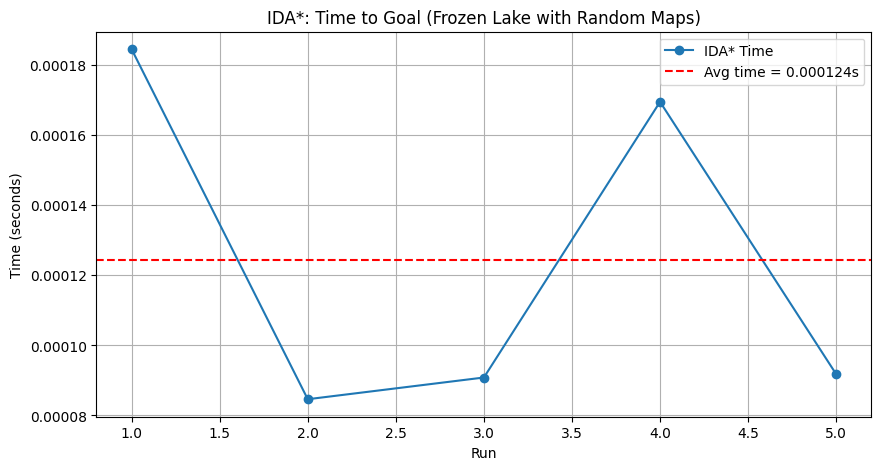

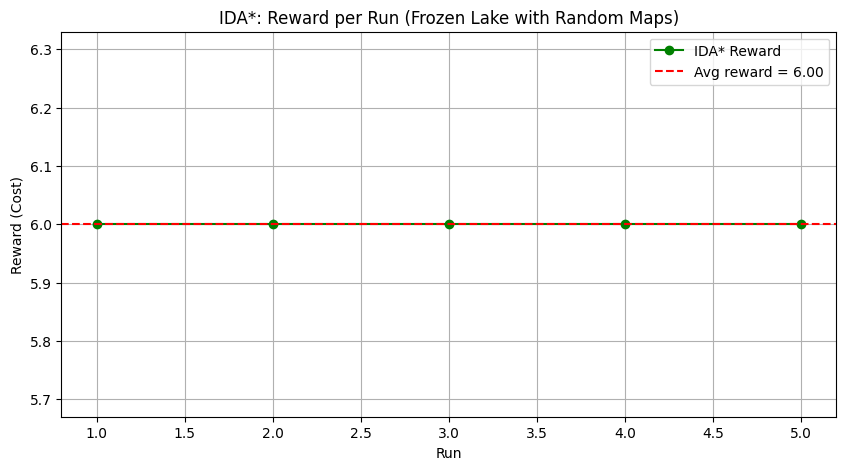

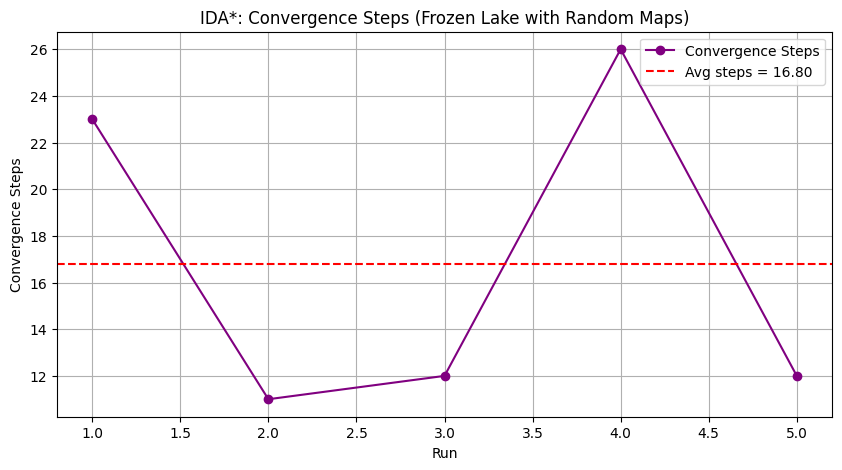


=== Performance Summary ===

Run 1 Map:
SFFF
FFHF
FHFF
FHHG
Time = 0.000185s, Reward = 6, Steps = 23

Run 2 Map:
SHFF
FFFF
FFFF
FHFG
Time = 0.000085s, Reward = 6, Steps = 11

Run 3 Map:
SFFF
FFHF
FFFF
HFHG
Time = 0.000091s, Reward = 6, Steps = 12

Run 4 Map:
SFFF
FFFF
FFHF
FFHG
Time = 0.000170s, Reward = 6, Steps = 26

Run 5 Map:
SFHH
HFHF
HFFF
FHFG
Time = 0.000092s, Reward = 6, Steps = 12

Average Time: 0.000124s
Average Reward: 6.00
Average Convergence Steps: 16.80


In [ ]:
import gymnasium as gym
import numpy as np
import time
import matplotlib.pyplot as plt
import imageio
from gymnasium.envs.toy_text.frozen_lake import generate_random_map

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Heuristic function: Manhattan Distance
def heuristic(state, goal, size=4):
    x1, y1 = state // size, state % size
    x2, y2 = goal // size, goal % size
    return abs(x1 - x2) + abs(y1 - y2)

# IDA* Algorithm with enhancements
def ida_star(env, start, goal, max_time=600):
    unwrapped_env = env.unwrapped
    size = int(np.sqrt(env.observation_space.n))
    steps = 0

    def search(path, g, bound):
        nonlocal steps
        steps += 1
        node = path[-1]
        f = g + heuristic(node, goal, size)
        if f > bound:
            return f
        if node == goal:
            return "FOUND"
        min_cost = float('inf')

        # Get all possible actions
        for action in range(env.action_space.n):
            # Get all possible transitions for this action
            for prob, next_state, reward, done in unwrapped_env.P[node][action]:
                if prob > 0 and next_state not in path:
                    path.append(next_state)
                    t = search(path, g + 1, bound)
                    if t == "FOUND":
                        return "FOUND"
                    if t < min_cost:
                        min_cost = t
                    path.pop()
        return min_cost

    bound = heuristic(start, goal, size)
    path = [start]
    start_time = time.time()

    while True:
        if time.time() - start_time > max_time:
            print("Time limit exceeded. Terminating IDA*.")
            return None, float('inf'), steps

        t = search(path, 0, bound)
        if t == "FOUND":
            # Convert path of states to actions
            action_path = []
            for i in range(len(path) - 1):
                current_state = path[i]
                next_state = path[i + 1]
                # Find which action leads from current_state to next_state
                for action in range(env.action_space.n):
                    for prob, s, _, _ in unwrapped_env.P[current_state][action]:
                        if s == next_state and prob > 0:
                            action_path.append(action)
                            break
                    else:
                        continue
                    break
            return action_path, len(action_path), steps
        if t == float('inf'):
            return None, float('inf'), steps
        bound = t

#GIF generation function
def generate_gif(env, path, filename):
    frames = []
    state, _ = env.reset()
    frames.append(env.render())

    for action in path:
        state, reward, terminated, truncated, info = env.step(action)
        frames.append(env.render())
        if terminated or truncated:
            break

    # Ensure final state is shown
    for _ in range(5):
        frames.append(env.render())

    imageio.mimsave(filename, frames, fps=2)
    print(f"GIF saved as {filename}")

# Main execution
ida_performance = []
size = 4

for i in range(5):
    # Generate new random map for each run (goal stays at bottom-right)
    random_map = generate_random_map(size=size)
    env = gym.make('FrozenLake-v1', desc=random_map, is_slippery=False, render_mode="rgb_array")

    # Goal is always at bottom-right (size*size - 1)
    goal_state = env.observation_space.n - 1

    start_state, _ = env.reset()
    start_time = time.time()
    path, cost, steps = ida_star(env, start_state, goal_state)
    end_time = time.time()

    time_taken = end_time - start_time

    if path:
        print(f"\nMap for Run {i+1}:")
        for row in random_map:
            print(row)
        print(f"Start: (0, 0), Goal: ({goal_state//size}, {goal_state%size})")
        print(f"Run {i+1}: Solution found in {time_taken:.6f}s, Cost: {cost}, Path: {path}, Steps: {steps}")
        generate_gif(env, path, f"ida_run_{i+1}.gif")
        ida_performance.append({
            'time': time_taken,
            'reward': cost,
            'convergence_steps': steps,
            'map': random_map
        })
    else:
        print(f"Run {i+1}: No solution found within time limit.")
        ida_performance.append({
            'time': float('inf'),
            'reward': 0,
            'convergence_steps': steps,
            'map': random_map
        })
    env.close()

# Plotting performance
times = [p['time'] for p in ida_performance if p['time'] != float('inf')]
rewards = [p['reward'] for p in ida_performance]
convergence_steps = [p['convergence_steps'] for p in ida_performance]

# Plot time
plt.figure(figsize=(10, 5))
plt.plot(range(1, 6), times, marker='o', label="IDA* Time")
plt.axhline(y=np.mean(times), color='r', linestyle='--', label=f"Avg time = {np.mean(times):.6f}s")
plt.xlabel("Run")
plt.ylabel("Time (seconds)")
plt.title("IDA*: Time to Goal (Frozen Lake with Random Maps)")
plt.legend()
plt.grid(True)
plt.show()

# Plot rewards
plt.figure(figsize=(10, 5))
plt.plot(range(1, 6), rewards, marker='o', color='green', label="IDA* Reward")
plt.axhline(y=np.mean(rewards), color='r', linestyle='--', label=f"Avg reward = {np.mean(rewards):.2f}")
plt.xlabel("Run")
plt.ylabel("Reward (Cost)")
plt.title("IDA*: Reward per Run (Frozen Lake with Random Maps)")
plt.legend()
plt.grid(True)
plt.show()

# Plot convergence steps
plt.figure(figsize=(10, 5))
plt.plot(range(1, 6), convergence_steps, marker='o', color='purple', label="Convergence Steps")
plt.axhline(y=np.mean(convergence_steps), color='r', linestyle='--', label=f"Avg steps = {np.mean(convergence_steps):.2f}")
plt.xlabel("Run")
plt.ylabel("Convergence Steps")
plt.title("IDA*: Convergence Steps (Frozen Lake with Random Maps)")
plt.legend()
plt.grid(True)
plt.show()

# Summary with map information
print("\n=== Performance Summary ===")
for i, perf in enumerate(ida_performance):
    print(f"\nRun {i+1} Map:")
    for row in perf['map']:
        print(row)
    print(f"Time = {perf['time']:.6f}s, Reward = {perf['reward']}, Steps = {perf['convergence_steps']}")

print(f"\nAverage Time: {np.mean(times):.6f}s")
print(f"Average Reward: {np.mean(rewards):.2f}")
print(f"Average Convergence Steps: {np.mean(convergence_steps):.2f}")

**Changing Goal Position too**


Map for Run 1:
SFHF
GFHF
FHFF
FFFF
Start: (0, 0), Goal: (1, 0)
Run 1: Solution found in 0.000042s, Cost: 1, Path: [1], Steps: 2
GIF saved as ida_run_1.gif

Map for Run 2:
SFFG
FFFF
HFFF
FFFF
Start: (0, 0), Goal: (0, 3)
Run 2: Solution found in 0.000058s, Cost: 3, Path: [2, 2, 2], Steps: 7
GIF saved as ida_run_2.gif

Map for Run 3:
SFFF
FFFF
FHFG
FFFF
Start: (0, 0), Goal: (2, 3)
Run 3: Solution found in 0.000064s, Cost: 5, Path: [1, 2, 2, 1, 2], Steps: 12
GIF saved as ida_run_3.gif

Map for Run 4:
SHFF
FFFF
FFFF
FFFG
Start: (0, 0), Goal: (3, 3)
Run 4: Solution found in 0.000047s, Cost: 6, Path: [1, 1, 1, 2, 2, 2], Steps: 7
GIF saved as ida_run_4.gif

Map for Run 5:
SGFF
FFFF
FFFF
FFFF
Start: (0, 0), Goal: (0, 1)
Run 5: Solution found in 0.000030s, Cost: 1, Path: [2], Steps: 3
GIF saved as ida_run_5.gif


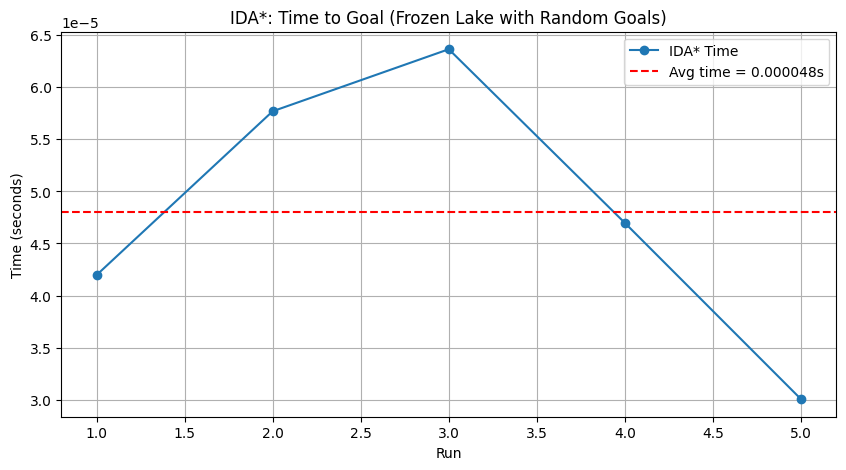

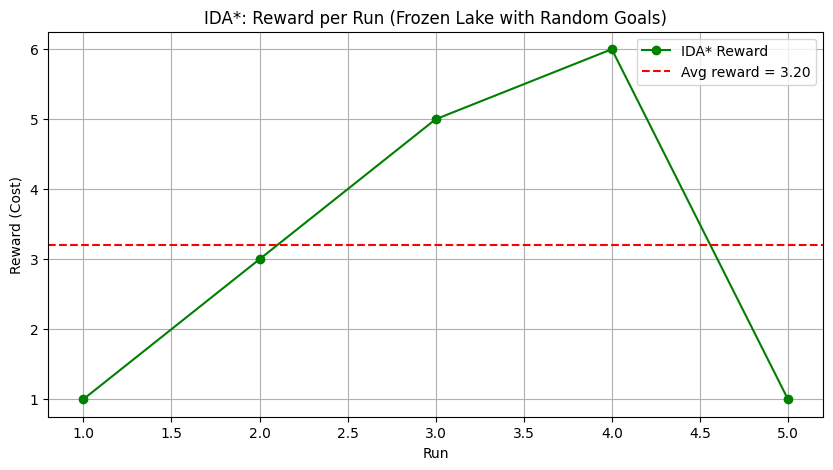

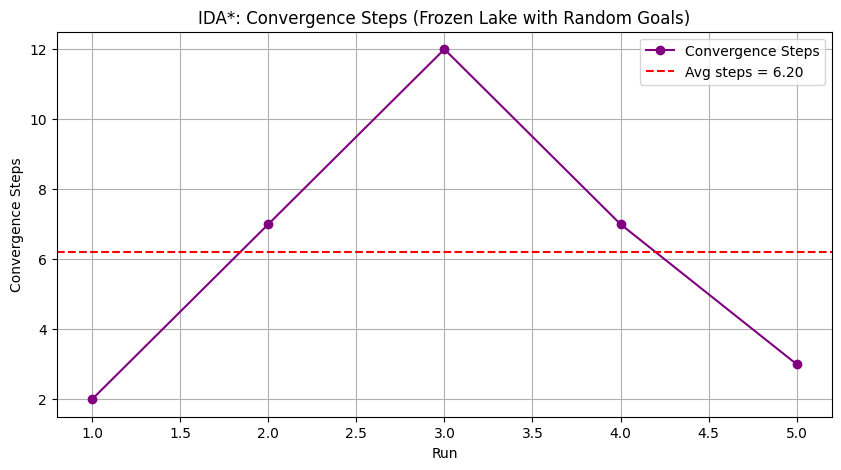


=== Performance Summary ===
Run 1: Goal Position (1, 0)
Time = 0.000042s, Reward = 1, Steps = 2

Run 2: Goal Position (0, 3)
Time = 0.000058s, Reward = 3, Steps = 7

Run 3: Goal Position (2, 3)
Time = 0.000064s, Reward = 5, Steps = 12

Run 4: Goal Position (3, 3)
Time = 0.000047s, Reward = 6, Steps = 7

Run 5: Goal Position (0, 1)
Time = 0.000030s, Reward = 1, Steps = 3

Average Time: 0.000048s
Average Reward: 3.20
Average Convergence Steps: 6.20


In [4]:
import gymnasium as gym
import numpy as np
import time
import matplotlib.pyplot as plt
import imageio
from gymnasium.envs.toy_text.frozen_lake import generate_random_map
import random

# Suppress warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

def generate_custom_map(size=4, goal_pos=None):
    """Generate a map with custom goal position"""
    base_map = generate_random_map(size=size)
    map_list = [list(row) for row in base_map]

    # Find current goal position (G)
    for i in range(size):
        for j in range(size):
            if map_list[i][j] == 'G':
                map_list[i][j] = 'F'  # Change old goal to frozen

    # Set new goal position
    if goal_pos is None:
        # Generate random position that's not the start (0,0) and not a hole
        while True:
            i, j = random.randint(0, size-1), random.randint(0, size-1)
            if (i, j) != (0, 0) and map_list[i][j] != 'H':
                map_list[i][j] = 'G'
                break
    else:
        i, j = goal_pos
        map_list[i][j] = 'G'

    return [''.join(row) for row in map_list]

# Heuristic function: Manhattan Distance
def heuristic(state, goal, size=4):
    x1, y1 = state // size, state % size
    x2, y2 = goal // size, goal % size
    return abs(x1 - x2) + abs(y1 - y2)

# IDA* Algorithm with enhancements
def ida_star(env, start, goal, max_time=600):
    unwrapped_env = env.unwrapped
    size = int(np.sqrt(env.observation_space.n))
    steps = 0

    def search(path, g, bound):
        nonlocal steps
        steps += 1
        node = path[-1]
        f = g + heuristic(node, goal, size)
        if f > bound:
            return f
        if node == goal:
            return "FOUND"
        min_cost = float('inf')

        # Get all possible actions
        for action in range(env.action_space.n):
            # Get all possible transitions for this action
            for prob, next_state, reward, done in unwrapped_env.P[node][action]:
                if prob > 0 and next_state not in path:
                    path.append(next_state)
                    t = search(path, g + 1, bound)
                    if t == "FOUND":
                        return "FOUND"
                    if t < min_cost:
                        min_cost = t
                    path.pop()
        return min_cost

    bound = heuristic(start, goal, size)
    path = [start]
    start_time = time.time()

    while True:
        if time.time() - start_time > max_time:
            print("Time limit exceeded. Terminating IDA*.")
            return None, float('inf'), steps

        t = search(path, 0, bound)
        if t == "FOUND":
            # Convert path of states to actions
            action_path = []
            for i in range(len(path) - 1):
                current_state = path[i]
                next_state = path[i + 1]
                # Find which action leads from current_state to next_state
                for action in range(env.action_space.n):
                    for prob, s, _, _ in unwrapped_env.P[current_state][action]:
                        if s == next_state and prob > 0:
                            action_path.append(action)
                            break
                    else:
                        continue
                    break
            return action_path, len(action_path), steps
        if t == float('inf'):
            return None, float('inf'), steps
        bound = t

# Enhanced GIF generation function
def generate_gif(env, path, filename):
    frames = []
    state, _ = env.reset()
    frames.append(env.render())

    for action in path:
        state, reward, terminated, truncated, info = env.step(action)
        frames.append(env.render())
        if terminated or truncated:
            break

    # Ensure final state is shown
    for _ in range(5):
        frames.append(env.render())

    imageio.mimsave(filename, frames, fps=2)
    print(f"GIF saved as {filename}")

# Main execution
ida_performance = []
size = 4

for i in range(5):
    # Generate map with random goal position
    custom_map = generate_custom_map(size=size)
    env = gym.make('FrozenLake-v1', desc=custom_map, is_slippery=False, render_mode="rgb_array")

    # Find goal position in the custom map
    goal_state = None
    for idx, row in enumerate(custom_map):
        if 'G' in row:
            goal_state = idx * size + row.index('G')
            break

    start_state, _ = env.reset()
    start_time = time.time()
    path, cost, steps = ida_star(env, start_state, goal_state)
    end_time = time.time()

    time_taken = end_time - start_time

    if path:
        print(f"\nMap for Run {i+1}:")
        for row in custom_map:
            print(row)
        print(f"Start: (0, 0), Goal: ({goal_state//size}, {goal_state%size})")
        print(f"Run {i+1}: Solution found in {time_taken:.6f}s, Cost: {cost}, Path: {path}, Steps: {steps}")
        generate_gif(env, path, f"ida_run_{i+1}.gif")
        ida_performance.append({
            'time': time_taken,
            'reward': cost,
            'convergence_steps': steps,
            'goal_pos': (goal_state//size, goal_state%size)
        })
    else:
        print(f"Run {i+1}: No solution found within time limit.")
        ida_performance.append({
            'time': float('inf'),
            'reward': 0,
            'convergence_steps': steps,
            'goal_pos': (goal_state//size, goal_state%size)
        })
    env.close()

# Plotting performance
times = [p['time'] for p in ida_performance if p['time'] != float('inf')]
rewards = [p['reward'] for p in ida_performance]
convergence_steps = [p['convergence_steps'] for p in ida_performance]
goal_positions = [p['goal_pos'] for p in ida_performance]

# Plot time
plt.figure(figsize=(10, 5))
plt.plot(range(1, 6), times, marker='o', label="IDA* Time")
plt.axhline(y=np.mean(times), color='r', linestyle='--', label=f"Avg time = {np.mean(times):.6f}s")
plt.xlabel("Run")
plt.ylabel("Time (seconds)")
plt.title("IDA*: Time to Goal (Frozen Lake with Random Goals)")
plt.legend()
plt.grid(True)
plt.show()

# Plot rewards
plt.figure(figsize=(10, 5))
plt.plot(range(1, 6), rewards, marker='o', color='green', label="IDA* Reward")
plt.axhline(y=np.mean(rewards), color='r', linestyle='--', label=f"Avg reward = {np.mean(rewards):.2f}")
plt.xlabel("Run")
plt.ylabel("Reward (Cost)")
plt.title("IDA*: Reward per Run (Frozen Lake with Random Goals)")
plt.legend()
plt.grid(True)
plt.show()

# Plot convergence steps
plt.figure(figsize=(10, 5))
plt.plot(range(1, 6), convergence_steps, marker='o', color='purple', label="Convergence Steps")
plt.axhline(y=np.mean(convergence_steps), color='r', linestyle='--', label=f"Avg steps = {np.mean(convergence_steps):.2f}")
plt.xlabel("Run")
plt.ylabel("Convergence Steps")
plt.title("IDA*: Convergence Steps (Frozen Lake with Random Goals)")
plt.legend()
plt.grid(True)
plt.show()

# Summary with goal positions
print("\n=== Performance Summary ===")
for i, perf in enumerate(ida_performance):
    print(f"Run {i+1}: Goal Position {perf['goal_pos']}")
    print(f"Time = {perf['time']:.6f}s, Reward = {perf['reward']}, Steps = {perf['convergence_steps']}\n")

print(f"Average Time: {np.mean(times):.6f}s")
print(f"Average Reward: {np.mean(rewards):.2f}")
print(f"Average Convergence Steps: {np.mean(convergence_steps):.2f}")